# Single-layer NN

In this file a neural network algorithm is created from scratch using only NumPy and the MNIST dataset. The results will be compared under different normalization/activation settings of the same architecture.

**This code is part of a Machine Learning assignment from Stockholm University**

## 1. Data preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

The MNIST dataset was constructed from two datasets of the US National Institute
of Standards and Technology (NIST). The training dataset consists of handwritten
digits from 250 different people, 50 percent high school students and 50 percent
employees from the Census Bureau. Note that the test dataset contains handwritten digits from different people following the same split.

![alt text](https://dezyre.gumlet.net/images/Exploring+MNIST+Dataset+using+PyTorch+to+Train+an+MLP/MNIST+Dataset.png?w=900&dpr=1.0)

This MNIST dataset can be directly downloaded using scikit-learn.

In [2]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

It has 70,000 different handwriting instances. It usually has 60,000 instances as a training set and the remaining ones as a test set, but scikit-learn loads it as a whole.

In [3]:
X.shape, y.shape

((70000, 784), (70000,))

We can also check the class distribution

<BarContainer object of 10 artists>

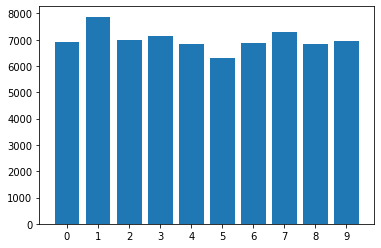

In [4]:
plt.bar(np.unique(y, return_counts = True)[0], np.unique(y, return_counts = True)[1])

Since it is clear that its maximum value is 255, the data can be normalized by dividing the whole value by 255.

In [5]:
X_normalized = X / 255

Since `y`has string labels they are convered to integer form for later.

In [6]:
y_integer = y.astype(int)

Next the dataset is split into two parts using scikit-learn's `train_test_split` method.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_integer, stratify=y_integer, test_size=10000, random_state=12345)

Some of the instances can be seen below.

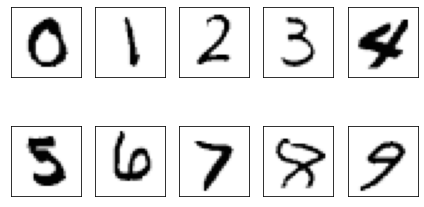

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
  img = X_train[y_train == i][0].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## 2. Helper functions

Since labels are in a sparse form, one-hot encoding for better computation using NumPy's vectorization is used.

In [9]:
def one_hot(y):
  """
  Input:
    - y : set of labels

  Output:
    - onehot: a one-hot-encoded array

  This function creates an one-hot encoded representation of the labels.
  This means that you will have a set of binary columns indicading each possible class.
  """

  onehot = np.zeros((y.size, y.max() + 1))
  onehot[np.arange(y.size), y] = 1
  
  return onehot


The expected outcome of the one-hot encoding is as follows:

In [10]:
one_hot(np.array([1,0,2,3]))

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

Next we may also need a sigmoid function for the output values as we are dealing with a classification problem. Sigmoid can be represented as follows:

$$ h_ \theta (x) =  \frac{\mathrm{1} }{\mathrm{1} + e^{-x} }  $$ 


In [11]:
def sigmoid(x):
  """
  Input:
    - x: input vector or scalar value

  Output:
    - sigmoid: output sigmoid-transformed vector or scalar value
  """

  sigmoid = 1 / (1 + np.exp(-x))

  return sigmoid

The expected result of the sigmoid function is as follows:

In [12]:
sigmoid(np.array([np.inf, -np.inf, 0]))

array([1. , 0. , 0.5])

## 3. Our FCN classifier with the class structure

This section will create a neural network model from scratch. We will eventually integrate everything into scikit-learn's pipeline, so it's important to have an appropriate class structure. To do this, you may need to extend `BaseEstimator` and `TransformerMixin` to make scikit-learn recognize that our class is a valid classifier.

We are going to develop a neural network with one layer for simplicity. That means we will have two different sets of weights.

- First layer: [input size (number of features), hidden layer size]
- Second layer: [hidden layer size, output size (number of classes)]

In our class structure `FullyConnectedNetwork`, we will develop five different methods as follows:
 - `compile`: Given parameters, we will initialize weight and bias values needed for our neural network model.
   - Here, you will initialize bias and weights based on chosen initialization technique.
        - We will have three different options: normal, Xavier, and he
        - Each technique initializes the weight using the normal distribution but different standard deviation.
          - Normal: 
$ \mu = 0, \sigma = 0.1 $
          - Xavier: 
$ \mu = 0, \sigma = \sqrt{\frac{2}{n_{in} + n_{out}}}$
          - He:
$ \mu = 0, \sigma = \sqrt{\frac{2}{n_{in}}}$
 - `forward`: Perform a forward propagation
 - `back_propagation`: Perform a back propagation
    - You will only need to finish some part of it.
      - Weight and bias update
      - Derivative of the sigmoid function
        - $σ(x)=σ(x)(1−σ(x))$.

 - `fit`: Run the whole fitting process (forward and backpropagation for each batch)
 - `cost`: Calculate the cost (cross-entropy) together with the elastic net (l1/l2)
   - cross-entropy loss can be calculated as follows:
 - `predict`: With a trained model, perform a prediction of unseen data by running the forward propagation with the trained weight and bias.
 - `evaluate`: With trained weight and bias, perform a prediction of test data and calculate the performance metric (in our case, those are training and validation accuracy scores).


In [13]:
class FullyConnectedNetwork(BaseEstimator, TransformerMixin):
    def __init__(self, n_hidden=30, l2=0., l1=0., epochs=100, eta=0.001, validation_rate = 0.3,
                 shuffle=True, batch_size=1, init_technique = "normal", seed=None, debug=True):

        """
        Input:
          - n_hidden: Number of hidden nodes.
          - l2: Lambda value for L2-regularization.
          - epochs: Number of passes over the training set.
          - eta: Learning rate.
          - shuffle: Enabling shuffling option of the dataset every epoch.
          - batch_size: Number of training examples per batch.
          - seed: Random seed for initializing weights and shuffling.
        """
        self.seed = seed
        self.random = np.random.RandomState(self.seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.l1 = l1
        self.epochs = epochs
        self.eta = eta
        self.validation_rate = validation_rate
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.debug = debug
        self.init_technique = init_technique

    def compile(self, n_features, n_outputs):
        """
        Initializing the weights of the model

        - Here you will initialize bias and weights based on chosen initialization technique.
        - We will have three different options: normal, xavier, and he
        - Each technique initializes the weight using the normal distribution but different standard deviation.
        - Use self.init_technique to check the chosen technique and use self.random to perform the sampling.

        Input:
          - n_features: input size of the network
          - n_outputs: output size of the network
          - Unit size of the layer is given as self.n_hidden
        """

        self.B = []
        self.W = []

        # Creating weights and bias for input -> hidden
        # Use specific initialization techniques for weights
        # Weights should have the size (n_features, self.n_hidden)
        # Use np.zeros for bias with the size 'self.n_hidden'

        b_h = np.zeros((self.n_hidden))
        w_h = np.ones((n_features, self.n_hidden))
        #normal
        if self.init_technique == "normal":
          w_h = self.random.normal(loc=0.0, scale=0.1,size=(n_features, self.n_hidden))
        #xavier
        elif self.init_technique == "xavier":
          xavier = np.sqrt(2 / (n_features + self.n_hidden))
          w_h = self.random.normal(loc=0.0, scale=xavier,size=(n_features, self.n_hidden))
        #he
        elif self.init_technique == "he":
          he = np.sqrt(2 / n_features)
          w_h = self.random.normal(loc=0.0, scale=he,size=(n_features, self.n_hidden))
        #error
        else:
          raise ValueError("Initialization not supported")
        # Append bias to self.B and weights to self.W
        self.B.append(b_h)
        self.W.append(w_h)

        # Creating weights and bias for hidden -> output
        # Use specific initialization techniques for weights
        # Weights should have the size (self.n_hidden, n_outputs)
        # Use np.zeros for bias with the size 'n_outputs'

        b_out = np.zeros((n_outputs))
        w_out = np.ones((self.n_hidden, n_outputs))
        #normal
        if self.init_technique == "normal":
          w_out = self.random.normal(loc=0.0, scale=0.1,size=(self.n_hidden, n_outputs))
        #xavier
        elif self.init_technique == "xavier":
          xavier = np.sqrt(2 / (self.n_hidden + n_outputs))
          w_out = self.random.normal(loc=0.0, scale=xavier,size=(self.n_hidden, n_outputs))
        #he
        elif self.init_technique == "he":
          he = np.sqrt(2 / self.n_hidden)
          w_out = self.random.normal(loc=0.0, scale=he,size=(self.n_hidden, n_outputs))
        #error
        else:
          raise ValueError("Initialization not supported")
        # Append bias to self.B and weights to self.W
        self.B.append(b_out)
        self.W.append(w_out)
        

    def forward(self, X):
        """
        Given the dataset X, compute forward propagation step with the weights and bias saved in the list.
        This process eventually outputs ten numbers in our case as we have ten outputs.
        Forward propagation is performed by multiple chained dot products of inputs and weights.
        
        Input:
          - X: features
        
        Output:
          - Z: Result of dot product of the weights and the previous output for each phase
          - A: A list that contains sigmoided values of A
        """

        Z = []
        A = []

        # net input of hidden layer
        # - take a dot product of the input features and the initial weights
        # - add the outcome to list Z
        Z.append(np.dot(X, self.W[0]) + self.B[0])

        # activation of hidden layer
        # - apply the sigmoid function to the dot producted outcome
        # - add the outcome to list A
        A.append(sigmoid(Z[0]))

        # net input of output layer
        # - take a dot product of the intermediate features and the weights of the output layer
        # - add the outcome to list Z
        Z.append(np.dot(A[0], self.W[1]) + self.B[1])

        # activation output layer
        # - apply the sigmoid function to the dot producted outcome
        # - add the outcome to list A
        A.append(sigmoid(Z[1]))

        return Z, A

    def predict(self, X):
        """
        
        Predict class labels by performing forward propagation.

        Input: 
          - X: feature matrix
        Output:
          - y_pred: Predicted class labels for all data instances.
        """

        # Run forward proparation on X and get Z, a.
        Z, A = self.forward(X)
        # Calculate y_pred by using the output (A[-1]) and with np.argmax - You have to choose the index of the one with the highest value
        y_pred = np.argmax(A[-1], axis=1)

        return y_pred

    def cost(self, y_truth, y_pred):
        """
        
        This function computes the cost for the classification task.
        We will also apply Elastic net (combination of l1 and l2)

        Input:
          - y_truth: "one-hot encoded" class labels.
          - y_pred: Activation of the output layer (= output of the forward propagation function)
          - the weights for l1 and l2 are saved into self.l1 and self.l2
        
        Output:
          - cost: Regularized cost
        """

        # Calculate the cross entropy between the truth and predicted values.
        cross_entropy = np.sum((-y_truth * np.log(y_pred)) - ((1 - y_truth) * np.log(1 - y_pred)))
        (- np.sum(y_truth * np.log(y_pred))) / float(y_pred.shape[0])
        # Add l1 and l2 terms to the cost.
        #    - L1 term is the sum of absolute weight values
        #    - L2 term is the sum of squared weight values
        #    - You should multiply l1 and l2 ratio saved in self.l1 and self.l2
        #    - You should NOT include weights that belong to the bias values.
        l1 = self.l1 * (np.sum(np.absolute(self.W[0])) + np.sum(np.absolute(self.W[1])))
        l2 = self.l2 * (np.sum(np.square(self.W[0])) + np.sum(np.square(self.W[1])))
        # Return the total cost (cross entropy + L1 term + L2 term).
        cost = cross_entropy + l1 + l2
        
        return cost

    

    def back_propagation(self, X_train, batch_idx, A, y_truth):
      """
      Perform back propagation based on the result of forward propagation and true labels (for each batch).

      Input:
        X_train: training features
        batch_idx: the current batch indices from the fit function
        A: Sigmoided output values - the result of forward propagation
        y_truth: One-hot encoded true labels

      Output:
        None
        You should update the weights and biases in self.W/self.B

      To get more information about the backpropagation process: 
           https://towardsdatascience.com/deriving-backpropagation-with-cross-entropy-loss-d24811edeaf9 ****
      """

      # OUTPUT WEIGHTS (LAYER-OUTPUT)

      # δC/δA * δA/δZ
      delta_out = A[-1] - y_truth[batch_idx]
      # δC/δA * δA/δZ * δZ/δW
      grad_w_out = np.dot(A[0].T, delta_out)
      # δC/δA * δA/δZ * δZ/δB
      grad_b_out = np.sum(delta_out, axis=0)

      # Using the final gradients of the weight and bias (grad_w_out, grad_b_out), we need to update
      delta_w_out = grad_w_out + (self.l1 * self.W[1]) + (self.l2 * self.W[1])
      delta_b_out = grad_b_out
      self.W[1] -= self.eta * delta_w_out
      self.B[1] -= self.eta * delta_b_out

      #############################################
      
      # HIDDEN WEIGHTS (INPUT-LAYER)

      #############################################

      # To continue to take derivatives backwards, we need to be able to take a derivative of the sigmoid function.
      # Here we are trying to take derivative of a sigmoided output A[0].
      # Derivative of sigmoid σ(x) can be represented as σ(x)(1−σ(x)).
      
      sigmoid_derivative_h = A[0] * (1 - A[0])

      delta_h = (np.dot(delta_out, self.W[1].T) * sigmoid_derivative_h)
      grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
      grad_b_h = np.sum(delta_h, axis=0)

      # Using the final gradients of the weight and bias (grad_w_h, grad_b_h), we need to update

      delta_w_h = grad_w_h + (self.l2 * self.W[0]) + (self.l2 * self.W[0])
      delta_b_h = grad_b_h
      
      self.W[0] -= self.eta * delta_w_h
      self.B[0] -= self.eta * delta_b_h

    
    def evaluate(self, epoch, X_train, X_valid, y_train, y_valid):
      """
      Evaluate performances on the training and validation sets per epoch
      
      Input:
        - epoch: current epoch number
        - X_train: training features
        - X_valid: validation features
        - y_train: training labels
        - y_valid: validation labels

      Output:
        - None
      """

      # Call self.forward on X_train to calculate the output with current weights and bias of the model
      Z, A = self.forward(X_train)

      # call predict functions with both X_train and X_valid and save the predicted values accordingly
      y_train_pred = self.predict(X_train)
      y_valid_pred = self.predict(X_valid)

      # Call self.cost with y_train and y_train_pred
      # save it into the variable 'cost'
      cost = self.cost(one_hot(y_train), A[1])

      # Calculate accuracy scores 
      # - between y_train_pred and y_train
      # - between y_valid_pred and y_valid
      train_acc = np.sum(y_train_pred == y_train).astype(np.float) / X_train.shape[0]
      valid_acc = np.sum(y_valid_pred == y_valid).astype(np.float) / X_valid.shape[0]

      # Save the results into the dictionary
      if self.debug == True:
        print('%d/%d | Cost: %.2f '
                        '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                        (epoch+1, self.epochs, cost,
                          train_acc*100, valid_acc*100))

      self.history['cost'].append(cost)
      self.history['train_acc'].append(train_acc)
      self.history['valid_acc'].append(valid_acc)

    
    def fit(self, X, y):
        """ 
        Learn weights from training data.

        Input
          - X: features (training+validation)
          - y: labels

        Output
          - self.history: information about cost and accuracy scores

        """

        self.history = {'cost': [], 'train_acc': [], 'valid_acc': []}

        # Select different training and test sets. Use scikit-learn's train_test_split.
        # Turn on the stratification option and use self.validation_rate
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=self.validation_rate, random_state=self.seed)

        #  Compile (initialize) the parameters by running self.compile with correct number of features and outputs
        self.compile(X_train.shape[1], len(np.unique(y_train)))

        # Prepare one-hot encoded training labels by using one_hot function on y_train
        y_train_enc = one_hot(y_train)

        # iterate over training epochs
        for i in range(self.epochs):

            # set the indices
            # - if self.shuffle is True, shuffle the indices using self.random.shuffle or permutation
            indices = np.arange(len(X_train))
            if self.shuffle:
              self.random.permutation(len(X_train))

            # iterate over the data
            # - For each iteration choose the data 
            for start_idx in range(0, indices.shape[0] - self.batch_size +
                                   1, self.batch_size):
                batch_idx = indices[start_idx:start_idx + self.batch_size]
                # Run a forward propagation
                Z, A = self.forward(X_train[batch_idx])
                # Run back propagation 
                # - Use X_train, batch_idx, A, and y_train_enc
                self.back_propagation(X_train, batch_idx, A, y_train_enc)

            # call evaluate function after inner loop (whole batch cycles) is complete
            self.evaluate(i, X_train, X_valid, y_train, y_valid)

        # After all loops are complete, return self.history
        return self.history

    def transform(self, X, y=None):
      return self.history
    
    def score(self, X, y=None):

      y_pred = self.predict(X)
      acc = np.sum(y == y_pred) / X.shape[0]
      return acc

Create a new instance

In [14]:
nn = FullyConnectedNetwork(n_hidden=100, l2=0.01, epochs=100, eta=0.0005, batch_size=100, shuffle=True, seed=12345)

We will try to run 100 epochs
 - Train the network on `X_train` and `y_train` and save the output to `history`.

In [15]:
history = nn.fit(X_train, y_train)

1/100 | Cost: 71808.55 | Train/Valid Acc.: 77.70%/78.25% 
2/100 | Cost: 51935.61 | Train/Valid Acc.: 84.31%/84.64% 
3/100 | Cost: 42962.07 | Train/Valid Acc.: 87.00%/86.96% 
4/100 | Cost: 37745.88 | Train/Valid Acc.: 88.34%/88.16% 
5/100 | Cost: 34391.94 | Train/Valid Acc.: 89.11%/88.98% 
6/100 | Cost: 32059.90 | Train/Valid Acc.: 89.65%/89.54% 
7/100 | Cost: 30320.90 | Train/Valid Acc.: 90.05%/89.89% 
8/100 | Cost: 28949.60 | Train/Valid Acc.: 90.40%/90.20% 
9/100 | Cost: 27821.26 | Train/Valid Acc.: 90.71%/90.51% 
10/100 | Cost: 26862.35 | Train/Valid Acc.: 90.98%/90.81% 
11/100 | Cost: 26026.98 | Train/Valid Acc.: 91.27%/91.05% 
12/100 | Cost: 25285.17 | Train/Valid Acc.: 91.51%/91.24% 
13/100 | Cost: 24616.55 | Train/Valid Acc.: 91.71%/91.43% 
14/100 | Cost: 24006.83 | Train/Valid Acc.: 91.90%/91.66% 
15/100 | Cost: 23445.72 | Train/Valid Acc.: 92.13%/91.82% 
16/100 | Cost: 22925.55 | Train/Valid Acc.: 92.30%/92.01% 
17/100 | Cost: 22440.51 | Train/Valid Acc.: 92.42%/92.13% 
18/100

Plot of the training and validation accuracy scores over time using the `history` dictionary returned by the fit function.

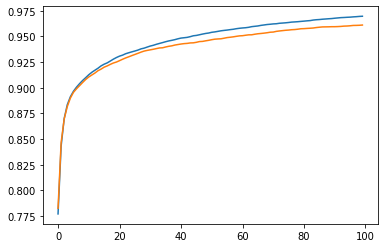

In [16]:
plt.plot(history['train_acc'])
plt.plot(history['valid_acc'])
plt.show()

## 4. Integrate classifier into the scikit-learn pipeline and the randomized search

This time, everything is integrated from the raw dataset to the performance metrics into scikit-learn pipeline. 

In [17]:
# Normalizer class that extends BaseEstimator and TransformerMixin.
#   - Normalizer: To make the features have the range [0, 1] and also center the points to zero by subtracting 0.5 from the values
#     using NumPy's broadcasting to calculate (X / 255) - 0.5.
class Normalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
      return self

    def transform(self, X):
      return (X / 255) - 0.5

# Pipeline that integrates both normalizer and neural network classifier.
pipe = Pipeline([('normalizer', Normalizer()), ('classifier', FullyConnectedNetwork(epochs=10))])

# Fit pipeline on the datasets (`X_train`, `y_train`).
X_train, X_test, y_train, y_test = train_test_split(X, y_integer, stratify=y_integer, train_size=60000, test_size=10000, random_state=12345)
pipe = pipe.fit(X_train, y_train)

1/10 | Cost: 71035.69 | Train/Valid Acc.: 79.80%/79.46% 
2/10 | Cost: 46622.60 | Train/Valid Acc.: 86.61%/86.73% 
3/10 | Cost: 37223.53 | Train/Valid Acc.: 88.65%/88.83% 
4/10 | Cost: 32299.40 | Train/Valid Acc.: 89.58%/89.82% 
5/10 | Cost: 29307.39 | Train/Valid Acc.: 90.23%/90.37% 
6/10 | Cost: 27264.55 | Train/Valid Acc.: 90.76%/90.93% 
7/10 | Cost: 25745.39 | Train/Valid Acc.: 91.19%/91.33% 
8/10 | Cost: 24546.40 | Train/Valid Acc.: 91.48%/91.74% 
9/10 | Cost: 23561.12 | Train/Valid Acc.: 91.79%/92.02% 
10/10 | Cost: 22729.33 | Train/Valid Acc.: 92.04%/92.26% 


In [18]:
# Score
pipeline_score = pipe.score(X_test, y_test)
print(pipeline_score)

0.9114


- Task 4: Randomized search
  - After constructing your pipeline, we will perform a randomized search on it.

In [19]:
# Define parameters
parameters = {
    'classifier__l1' : [0.001, 0.01, 0.1],
    'classifier__l2' : [0.001, 0.01, 0.1],
    'classifier__n_hidden' : [30, 50, 100],
    'classifier__eta' : [0.0001, 0.0005, 0.001],
    'classifier__init_technique' : ["normal", "xavier", "he"]
  }

# Run randomized search and fit
grid = RandomizedSearchCV(pipe, param_distributions=parameters, n_iter = 10, cv=3, random_state=12345)
grid.fit(X_train, y_train)

# Report best classifier and best score into the variables 
best_classifier = grid.best_estimator_
best_score = grid.best_score_

print(best_classifier, best_score)

1/10 | Cost: 90956.73 | Train/Valid Acc.: 10.02%/10.04% 
2/10 | Cost: 91182.39 | Train/Valid Acc.: 9.79%/9.78% 
3/10 | Cost: 91172.96 | Train/Valid Acc.: 9.79%/9.78% 
4/10 | Cost: 91140.62 | Train/Valid Acc.: 9.79%/9.78% 
5/10 | Cost: 91109.37 | Train/Valid Acc.: 9.79%/9.78% 
6/10 | Cost: 91083.10 | Train/Valid Acc.: 9.79%/9.78% 
7/10 | Cost: 91062.56 | Train/Valid Acc.: 9.79%/9.78% 
8/10 | Cost: 91047.54 | Train/Valid Acc.: 9.79%/9.78% 
9/10 | Cost: 91037.25 | Train/Valid Acc.: 9.79%/9.78% 
10/10 | Cost: 91030.62 | Train/Valid Acc.: 9.80%/9.81% 
1/10 | Cost: 90723.90 | Train/Valid Acc.: 11.32%/11.32% 
2/10 | Cost: 91082.14 | Train/Valid Acc.: 11.32%/11.32% 
3/10 | Cost: 91100.38 | Train/Valid Acc.: 11.32%/11.32% 
4/10 | Cost: 91075.25 | Train/Valid Acc.: 11.32%/11.32% 
5/10 | Cost: 91046.66 | Train/Valid Acc.: 11.32%/11.32% 
6/10 | Cost: 91022.23 | Train/Valid Acc.: 11.32%/11.32% 
7/10 | Cost: 91003.43 | Train/Valid Acc.: 11.32%/11.32% 
8/10 | Cost: 90990.09 | Train/Valid Acc.: 11.32%